In [12]:
import os, re, gzip
import numpy as np
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import scanpy as sc
import matplotlib.pyplot as plt
base_dir = '/Users/christoffer/Downloads/GSE212903_RAW/'

# list all relevant files with FULL PATHS
all_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir)]
all_files = [f for f in all_files
             if f.endswith(('.tsv.gz', '.mtx.gz'))
             and any(s in os.path.basename(f) for s in ('barcodes', 'features', 'matrix'))]

# ---- parse metadata from filename stem ----
# e.g. GSM6560897_Young_R01_S1_matrix.mtx.gz
rx = re.compile(r"^(GSM\d+)_(Young|Mid|Old)_R(\d+)_S(\d+)_")

def parse_meta_from_stem(stem: str):
    m = rx.match(os.path.basename(stem) + "_")  # ensure trailing underscore for the regex
    if not m:
        return {"GSM": None, "age_group": None, "run": None, "section": None}
    gsm, age, run, sec = m.groups()
    return {"GSM": gsm, "age_group": age, "run": f"R{run}", "section": f"S{sec}"}

# ---- read one triplet into AnnData ----
def read_10x_triplet(barcodes_path, features_path, matrix_path):
    # barcodes
    barcodes = pd.read_csv(barcodes_path, sep="\t", header=None)[0].astype(str).values

    # features (gene_id, gene_name, feature_type)
    feats = pd.read_csv(features_path, sep="\t", header=None)
    feats.columns = ["gene_id", "gene_name", "feature_type"][:feats.shape[1]]
    if "feature_type" in feats.columns:
        feats = feats.loc[feats["feature_type"] == "Gene Expression"].copy()

    # matrix (genes x cells) -> cells x genes
    with gzip.open(matrix_path, "rb") as fh:
        X = mmread(fh)
    X = csr_matrix(X).T

    # build var/obs
    var = pd.DataFrame(index=feats["gene_name"].astype(str).values)
    var["gene_id"] = feats["gene_id"].astype(str).values
    var.index.name = None

    obs = pd.DataFrame(index=barcodes)
    obs.index.name = None

    ad = sc.AnnData(X=X, obs=obs, var=var)
    ad.var_names_make_unique()
    ad.layers["counts"] = ad.X.copy()
    return ad

# ---- group files by sample stem ----
# stem = everything before _barcodes/_features/_matrix
samples = {}
for f in all_files:
    stem = re.sub(r"_(barcodes|features|matrix)\..*$", "", os.path.basename(f))
    samples.setdefault(stem, []).append(f)

def pick(flist, kw):
    for p in flist:
        if f"_{kw}" in os.path.basename(p):
            return p
    raise ValueError(f"Could not find '{kw}' in: {flist}")

ad_list = []
for stem, flist in samples.items():
    # require all three parts
    try:
        bar = pick(flist, "barcodes")
        feat = pick(flist, "features")
        mtx = pick(flist, "matrix")
    except ValueError:
        # skip incomplete triplets
        continue

    ad = read_10x_triplet(bar, feat, mtx)

    # annotate from stem
    meta = parse_meta_from_stem(stem)
    ad.obs["sample"] = stem
    ad.obs["GSM"] = meta["GSM"]
    ad.obs["age_group"] = meta["age_group"]   # Young / Mid / Old
    ad.obs["run"] = meta["run"]               # R01, R02, ...
    ad.obs["section"] = meta["section"]       # S1, S2, ...
    ad.obs["file_stem"] = stem

    ad_list.append(ad)

# ---- concatenate all samples safely ----
adata = sc.concat(
    ad_list,
    join="outer",
    label="sample",
    keys=[a.obs["sample"].iloc[0] for a in ad_list],
    index_unique="-",
    fill_value=0,
)

print(adata)
print(adata.obs[["sample", "GSM", "age_group", "run", "section"]].drop_duplicates().sort_values(["GSM","run","section"]))

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/

AnnData object with n_obs × n_vars = 16743 × 32285
    obs: 'sample', 'GSM', 'age_group', 'run', 'section', 'file_stem'
    layers: 'counts'
                                                             sample  \
AAACAAGTATCTCCCA-1-GSM6560897_Young_R01_S1  GSM6560897_Young_R01_S1   
AAACAAGTATCTCCCA-1-GSM6560898_Mid_R01_S1      GSM6560898_Mid_R01_S1   
AAACAAGTATCTCCCA-1-GSM6560899_Old_R01_S1      GSM6560899_Old_R01_S1   
AAACAAGTATCTCCCA-1-GSM6560900_Young_R02_S1  GSM6560900_Young_R02_S1   
AAACAAGTATCTCCCA-1-GSM6560901_Mid_R02_S2      GSM6560901_Mid_R02_S2   
AAACAAGTATCTCCCA-1-GSM6560902_Old_R02_S2      GSM6560902_Old_R02_S2   

                                                   GSM age_group  run section  
AAACAAGTATCTCCCA-1-GSM6560897_Young_R01_S1  GSM6560897     Young  R01      S1  
AAACAAGTATCTCCCA-1-GSM6560898_Mid_R01_S1    GSM6560898       Mid  R01      S1  
AAACAAGTATCTCCCA-1-GSM6560899_Old_R01_S1    GSM6560899       Old  R01      S1  
AAACAAGTATCTCCCA-1-GSM6560900_Young_R02_S

In [13]:
adata.obs

,sample,GSM,age_group,run,section,file_stem
AAACAAGTATCTCCCA-1-GSM6560899_Old_R01_S1,GSM6560899_Old_R01_S1,GSM6560899,Old,R01,S1,GSM6560899_Old_R01_S1
AAACACCAATAACTGC-1-GSM6560899_Old_R01_S1,GSM6560899_Old_R01_S1,GSM6560899,Old,R01,S1,GSM6560899_Old_R01_S1
AAACAGCTTTCAGAAG-1-GSM6560899_Old_R01_S1,GSM6560899_Old_R01_S1,GSM6560899,Old,R01,S1,GSM6560899_Old_R01_S1
AAACAGGGTCTATATT-1-GSM6560899_Old_R01_S1,GSM6560899_Old_R01_S1,GSM6560899,Old,R01,S1,GSM6560899_Old_R01_S1
AAACATGGTGAGAGGA-1-GSM6560899_Old_R01_S1,GSM6560899_Old_R01_S1,GSM6560899,Old,R01,S1,GSM6560899_Old_R01_S1
...,...,...,...,...,...,...
TTGTTCTAGATACGCT-1-GSM6560902_Old_R02_S2,GSM6560902_Old_R02_S2,GSM6560902,Old,R02,S2,GSM6560902_Old_R02_S2
TTGTTGTGTGTCAAGA-1-GSM6560902_Old_R02_S2,GSM6560902_Old_R02_S2,GSM6560902,Old,R02,S2,GSM6560902_Old_R02_S2
TTGTTTCACATCCAGG-1-GSM6560902_Old_R02_S2,GSM6560902_Old_R02_S2,GSM6560902,Old,R02,S2,GSM6560902_Old_R02_S2
TTGTTTCATTAGTCTA-1-GSM6560902_Old_R02_S2,GSM6560902_Old_R02_S2,GSM6560902,Old,R02,S2,GSM6560902_Old_R02_S2


In [14]:
# --- FULL CODE: wire Visium positions into AnnData ---

import os
import re
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# ------------------ CONFIG ------------------
# Folder containing subfolders like "Mid_R01_S1_spatial", "Old_R01_S1_spatial", ...
SPATIAL_BASE = "/Users/christoffer/Downloads/GSE212903_spatial/"
# --------------------------------------------

# 1) Build mapping: (age_group, run, section) -> absolute folder path
folder_key = {}
for d in os.listdir(SPATIAL_BASE):
    full = os.path.join(SPATIAL_BASE, d)
    if not (d.endswith("_spatial") and os.path.isdir(full)):
        continue
    parts = d.split("_")  # e.g. ["Mid","R01","S1","spatial"]
    if len(parts) >= 3:
        age, run, sec = parts[:3]
        folder_key[(age, run, sec)] = full

if not folder_key:
    raise RuntimeError(f"No *_spatial folders found under {SPATIAL_BASE}")

# 2) Helper to extract 10x barcode from obs_name
#    e.g. 'AAACAGATCTCCCA-1-GSM6560899_Old_R01_S1' -> 'AAACAGATCTCCCA-1'
def obsname_to_barcode(obsname: str):
    parts = obsname.split("-")
    return parts[0] + "-" + parts[1] if len(parts) >= 3 else obsname.split("-", 1)[0]

# 3) Ensure placeholder columns exist in adata.obs
for col in ["in_tissue", "array_row", "array_col", "pxl_row", "pxl_col"]:
    if col not in adata.obs.columns:
        adata.obs[col] = np.nan

# 4) Prepare obsm["spatial"] (pixel y, x)
spatial = np.full((adata.n_obs, 2), np.nan, dtype=float)  # columns: [pxl_row, pxl_col]

# 5) Iterate samples (grouped by age_group, run, section)
if not set(["age_group","run","section"]).issubset(adata.obs.columns):
    raise ValueError("adata.obs must contain 'age_group', 'run', 'section' columns.")

groups = adata.obs.groupby(["age_group", "run", "section"])
filled = 0

for (age, run, sec), idx in groups.indices.items():
    obs_idx = np.asarray(list(idx))  # integer positions in adata

    folder = folder_key.get((age, run, sec))
    if folder is None:
        print(f"⚠️  No spatial folder for {(age, run, sec)}")
        continue

    # Read tissue positions (old or new filename)
    csv_old = os.path.join(folder, "tissue_positions_list.csv")
    csv_new = os.path.join(folder, "tissue_positions.csv")
    if os.path.exists(csv_old):
        df = pd.read_csv(csv_old, header=None)
        df.columns = ["barcode", "in_tissue", "array_row", "array_col", "pxl_row", "pxl_col"]
    elif os.path.exists(csv_new):
        df = pd.read_csv(csv_new)
        needed = {"barcode","in_tissue","array_row","array_col","pxl_row","pxl_col"}
        miss = needed - set(df.columns)
        if miss:
            print(f"⚠️ Missing columns {miss} in {csv_new}; skipping {(age,run,sec)}")
            continue
    else:
        print(f"⚠️  No tissue_positions csv in {folder}; skipping {(age,run,sec)}")
        continue

    # Index by barcode
    df["barcode"] = df["barcode"].astype(str)
    df = df.set_index("barcode")

    # Barcodes for this sample in adata
    barcodes_idx = pd.Index(adata.obs_names[obs_idx]).map(obsname_to_barcode)

    # First try: barcodes with "-1" (or equivalent library suffix)
    mask_with = np.isin(barcodes_idx.values, df.index.values)
    if mask_with.any():
        pos = obs_idx[mask_with]
        df_match = df.reindex(barcodes_idx[mask_with])
    else:
        # Fallback: strip "-<digits>" suffix from both sides and match
        bar_wo = barcodes_idx.str.replace(r"-\d+$", "", regex=True)
        df_wo = df.copy()
        df_wo.index = pd.Index([b.split("-")[0] for b in df_wo.index])
        mask_wo = np.isin(bar_wo.values, df_wo.index.values)
        if not mask_wo.any():
            print(f"⚠️  No matching barcodes for {(age,run,sec)}")
            continue
        pos = obs_idx[mask_wo]
        df_match = df_wo.reindex(bar_wo[mask_wo])

    # Fill obsm["spatial"] (pixel coords)
    spatial[pos, 0] = pd.to_numeric(df_match["pxl_row"], errors="coerce").to_numpy(dtype=float)
    spatial[pos, 1] = pd.to_numeric(df_match["pxl_col"], errors="coerce").to_numpy(dtype=float)

    # Assign obs columns by LABEL (avoid KeyError)
    labels = adata.obs.index[pos]
    adata.obs.loc[labels, "in_tissue"] = pd.to_numeric(df_match["in_tissue"], errors="coerce").to_numpy()
    adata.obs.loc[labels, "array_row"] = pd.to_numeric(df_match["array_row"], errors="coerce").to_numpy()
    adata.obs.loc[labels, "array_col"] = pd.to_numeric(df_match["array_col"], errors="coerce").to_numpy()
    adata.obs.loc[labels, "pxl_row"]   = pd.to_numeric(df_match["pxl_row"],   errors="coerce").to_numpy()
    adata.obs.loc[labels, "pxl_col"]   = pd.to_numeric(df_match["pxl_col"],   errors="coerce").to_numpy()

    filled += len(pos)

# 6) Store coordinates
adata.obsm["spatial"] = spatial

print(f"Filled spatial for cells: {filled} / {adata.n_obs}")
print("Examples:\n", adata.obs.loc[adata.obs["in_tissue"].notna(), ["age_group","run","section","in_tissue","pxl_row","pxl_col"]].head())



Filled spatial for cells: 16743 / 16743
Examples:
                                          age_group  run section  in_tissue  \
AAACAAGTATCTCCCA-1-GSM6560899_Old_R01_S1       Old  R01      S1        1.0   
AAACACCAATAACTGC-1-GSM6560899_Old_R01_S1       Old  R01      S1        1.0   
AAACAGCTTTCAGAAG-1-GSM6560899_Old_R01_S1       Old  R01      S1        1.0   
AAACAGGGTCTATATT-1-GSM6560899_Old_R01_S1       Old  R01      S1        1.0   
AAACATGGTGAGAGGA-1-GSM6560899_Old_R01_S1       Old  R01      S1        1.0   

                                          pxl_row  pxl_col  
AAACAAGTATCTCCCA-1-GSM6560899_Old_R01_S1   5007.0   5855.0  
AAACACCAATAACTGC-1-GSM6560899_Old_R01_S1   5737.0   2126.0  
AAACAGCTTTCAGAAG-1-GSM6560899_Old_R01_S1   4488.0   1668.0  
AAACAGGGTCTATATT-1-GSM6560899_Old_R01_S1   4800.0   1850.0  
AAACATGGTGAGAGGA-1-GSM6560899_Old_R01_S1   5978.0   1273.0  


In [15]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [16]:
import seaborn as sns

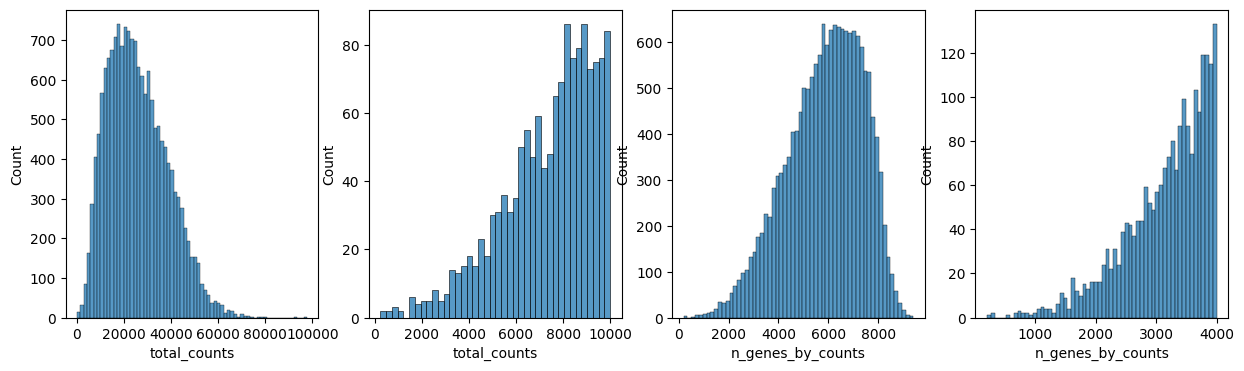

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)
plt.show()

In [18]:
adata[adata.obs["pct_counts_mt"] <15]

View of AnnData object with n_obs × n_vars = 16743 × 32285
    obs: 'sample', 'GSM', 'age_group', 'run', 'section', 'file_stem', 'in_tissue', 'array_row', 'array_col', 'pxl_row', 'pxl_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'
    layers: 'counts'

In [19]:
#sc.pp.filter_cells(adata, min_counts=100)
#sc.pp.filter_cells(adata, max_counts=35000)
#adata = adata[adata.obs["pct_counts_mt"] < 15].copy()
#print(f"#cells after MT filter: {adata.n_obs}")
#sc.pp.filter_genes(adata, min_cells=10)

In [20]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [21]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters", directed=False, n_iterations=2)

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute

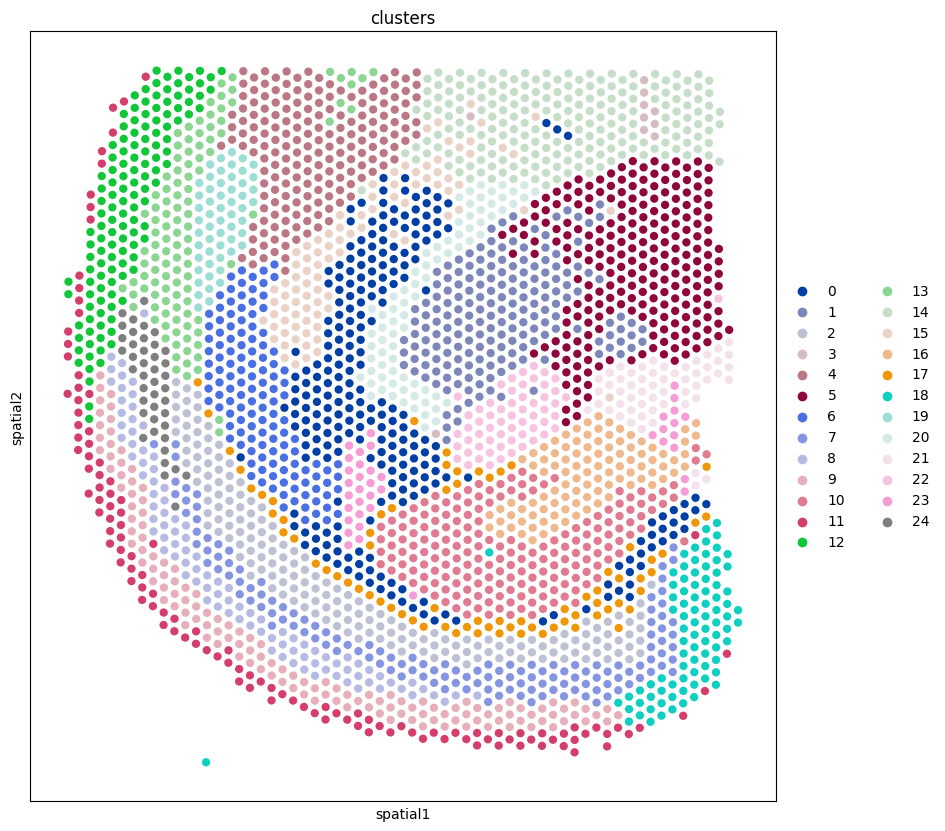

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute

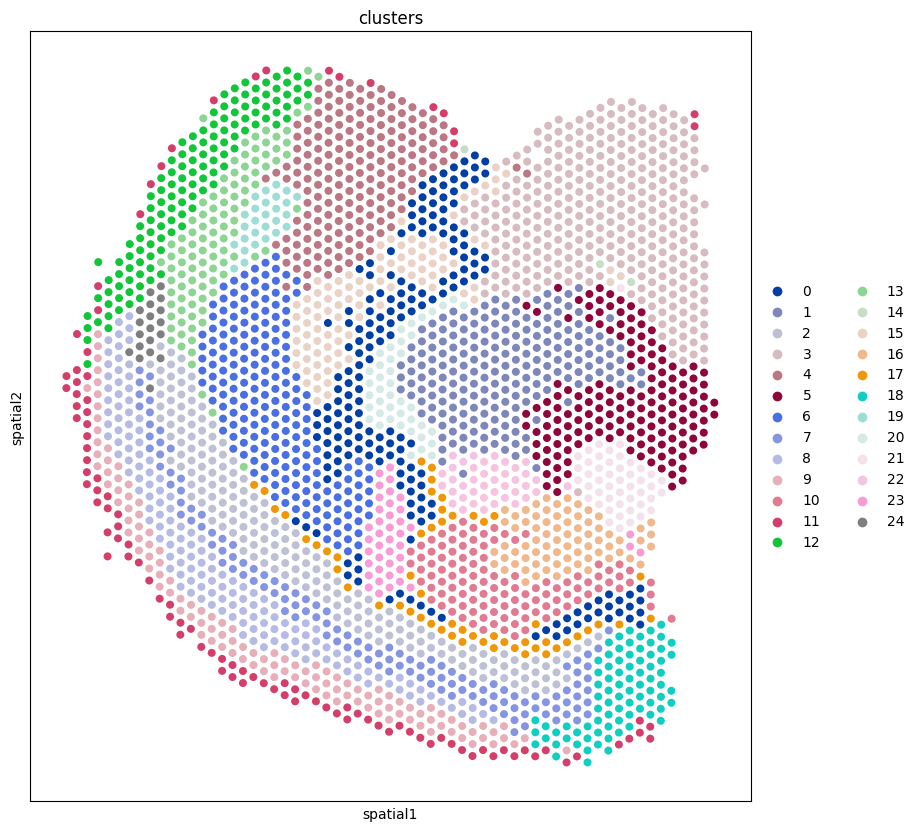

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute

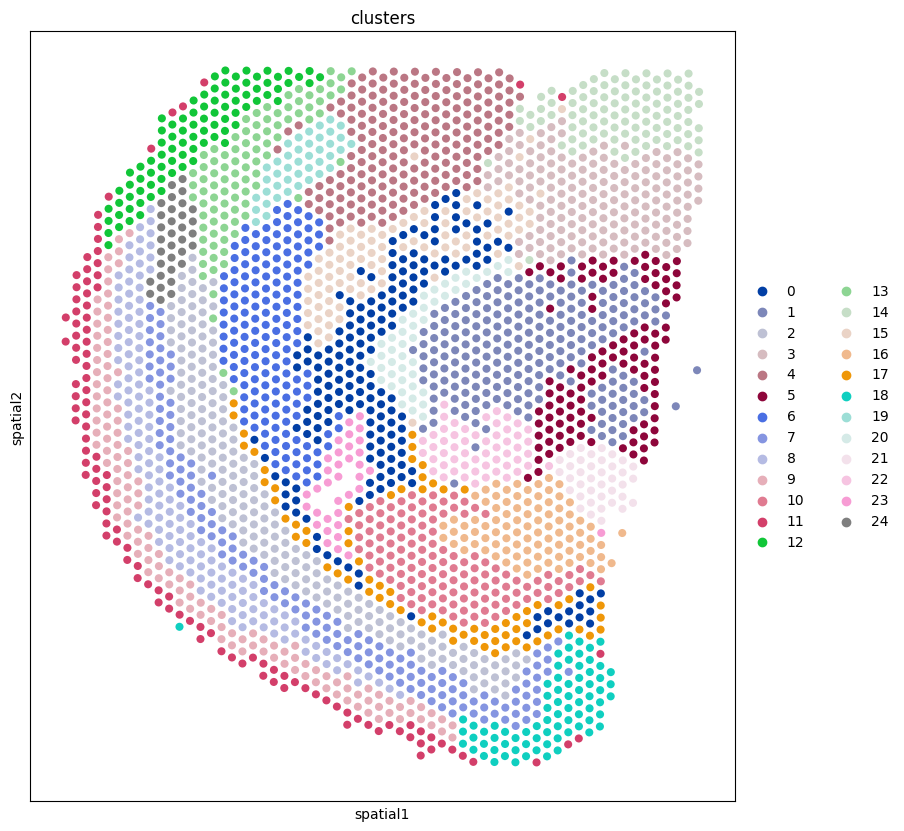

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute

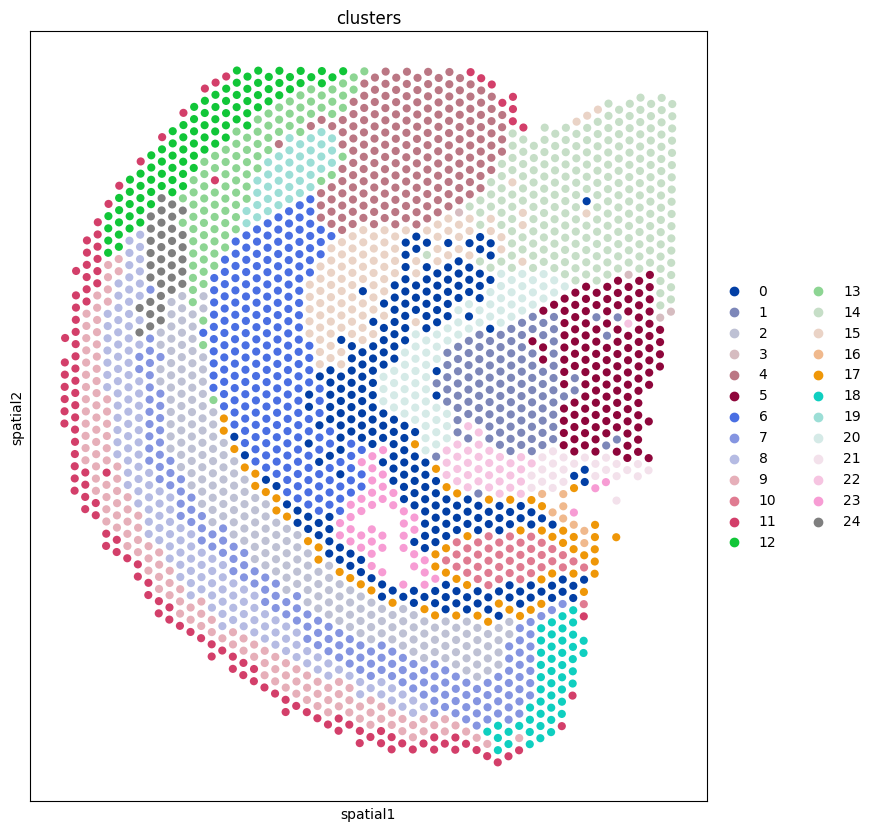

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute

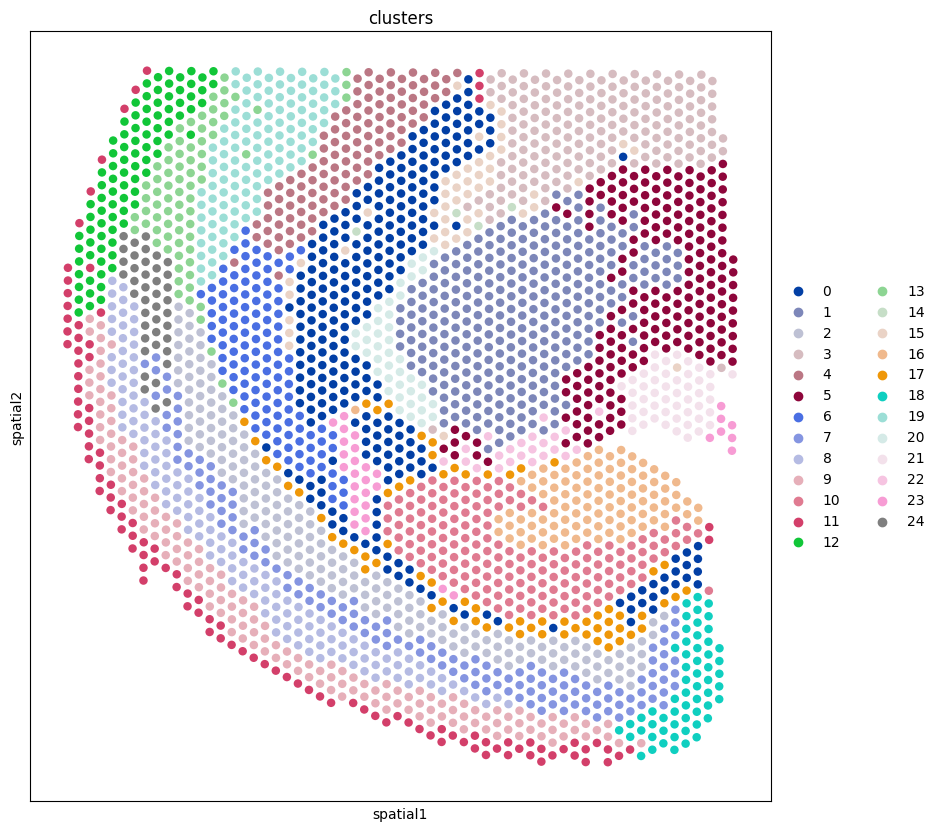

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute

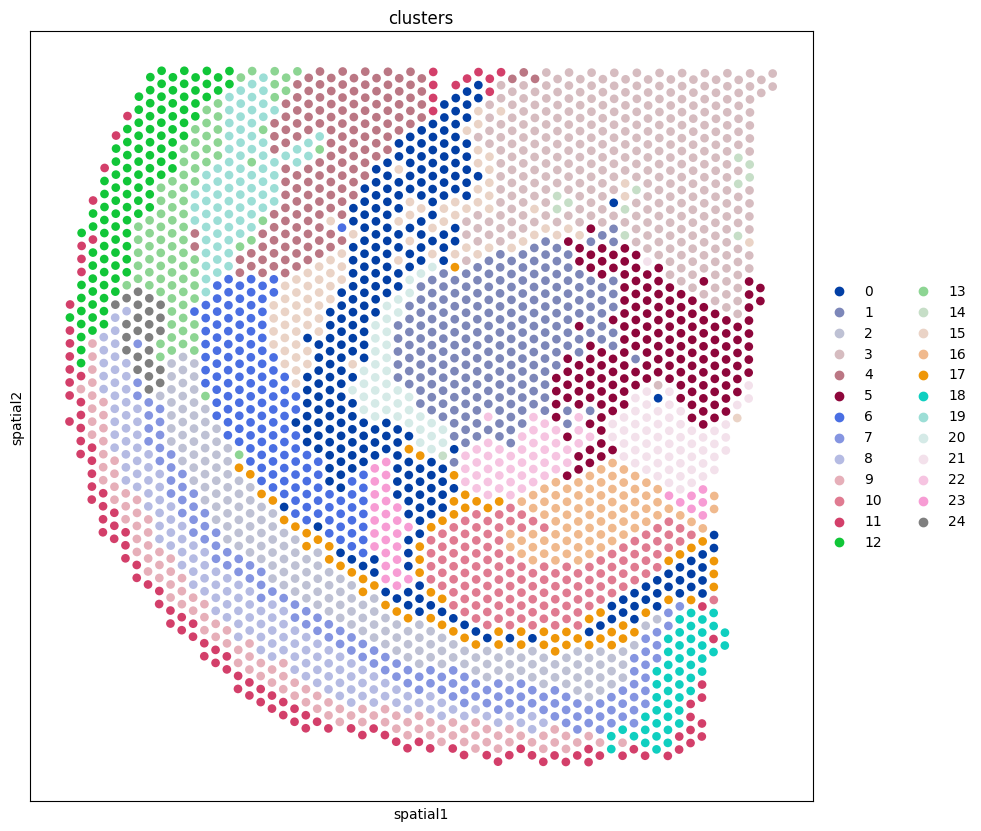

In [23]:
for run in adata.obs['sample'].unique():
    ad_int = adata[adata.obs['sample'] == run]
    with plt.rc_context({'figure.figsize': (20, 10)}):
        sc.pl.spatial(ad_int, spot_size=60, color = 'clusters')
    plt.show()
    

In [29]:
adata.obs

,sample,GSM,age_group,run,section,file_stem,in_tissue,array_row,array_col,pxl_row,...,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,clusters
AAACAAGTATCTCCCA-1-GSM6560899_Old_R01_S1,GSM6560899_Old_R01_S1,GSM6560899,Old,R01,S1,GSM6560899_Old_R01_S1,1.0,50.0,102.0,5007.0,...,50906,10.837756,23.154442,29.120339,36.989746,50.218049,0,0.0,0.0,9
AAACACCAATAACTGC-1-GSM6560899_Old_R01_S1,GSM6560899_Old_R01_S1,GSM6560899,Old,R01,S1,GSM6560899_Old_R01_S1,1.0,59.0,19.0,5737.0,...,24285,10.097655,28.029648,34.029236,41.898291,54.457484,0,0.0,0.0,5
AAACAGCTTTCAGAAG-1-GSM6560899_Old_R01_S1,GSM6560899_Old_R01_S1,GSM6560899,Old,R01,S1,GSM6560899_Old_R01_S1,1.0,43.0,9.0,4488.0,...,11141,9.318477,23.507764,30.203752,38.955210,53.199892,0,0.0,0.0,14
AAACAGGGTCTATATT-1-GSM6560899_Old_R01_S1,GSM6560899_Old_R01_S1,GSM6560899,Old,R01,S1,GSM6560899_Old_R01_S1,1.0,47.0,13.0,4800.0,...,10164,9.226706,26.239669,32.359307,40.535222,54.594648,0,0.0,0.0,14
AAACATGGTGAGAGGA-1-GSM6560899_Old_R01_S1,GSM6560899_Old_R01_S1,GSM6560899,Old,R01,S1,GSM6560899_Old_R01_S1,1.0,62.0,0.0,5978.0,...,37470,10.531323,23.746998,30.245530,38.881772,52.428610,0,0.0,0.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCTAGATACGCT-1-GSM6560902_Old_R02_S2,GSM6560902_Old_R02_S2,GSM6560902,Old,R02,S2,GSM6560902_Old_R02_S2,1.0,21.0,3.0,2520.0,...,17744,9.783859,27.423354,33.188683,41.146303,54.886159,0,0.0,0.0,12
TTGTTGTGTGTCAAGA-1-GSM6560902_Old_R02_S2,GSM6560902_Old_R02_S2,GSM6560902,Old,R02,S2,GSM6560902_Old_R02_S2,1.0,31.0,77.0,3287.0,...,27151,10.209206,15.925749,22.072852,30.363523,44.856543,0,0.0,0.0,2
TTGTTTCACATCCAGG-1-GSM6560902_Old_R02_S2,GSM6560902_Old_R02_S2,GSM6560902,Old,R02,S2,GSM6560902_Old_R02_S2,1.0,58.0,42.0,5407.0,...,8953,9.099856,22.271864,28.314531,36.256004,50.932648,0,0.0,0.0,5
TTGTTTCATTAGTCTA-1-GSM6560902_Old_R02_S2,GSM6560902_Old_R02_S2,GSM6560902,Old,R02,S2,GSM6560902_Old_R02_S2,1.0,60.0,30.0,5566.0,...,7799,8.961879,21.823311,28.516476,37.389409,52.570842,0,0.0,0.0,5


/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_57291/509333744.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="age_group", y="C4b_expr", inner="box", palette="muted")


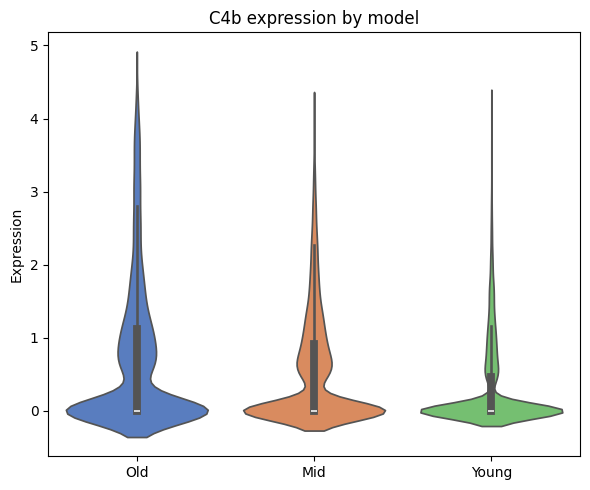

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# pick gene
gene = "C4b"

# extract expression vector
if gene not in adata.var_names:
    raise ValueError(f"{gene} not found in adata.var_names")

c4b_expr = adata[:, gene].X
if hasattr(c4b_expr, "toarray"):  # handle sparse matrix
    c4b_expr = c4b_expr.toarray().ravel()
else:
    c4b_expr = np.asarray(c4b_expr).ravel()

# build dataframe
df = pd.DataFrame({
    "C4b_expr": c4b_expr,
    "age_group": adata.obs["age_group"].values
})

plt.figure(figsize=(6,5))
sns.violinplot(data=df, x="age_group", y="C4b_expr", inner="box", palette="muted")
plt.title("C4b expression by model")
plt.ylabel("Expression")
plt.xlabel("")
plt.tight_layout()
plt.show()

In [ ]:
 sc.pl.dotplot(
        adata,
        var_names=['C4b', 'Serpina3n'],
        groupby="age_group",
        standard_scale="var",
        #dot_max=0.5,
        #dot_min=0.05,
        color_map="Reds",
        dendrogram=True,
        figsize=(4, 10)
    )

# correlation

In [37]:
import numpy as np
import pandas as pd

# Subset to DA-oligos only
# Extract C4b expression vector
c4b_idx = adata.var_names.get_loc("C4b")
c4b_expr = adata.X[:, c4b_idx].toarray().ravel() if hasattr(adata.X, "toarray") else adata.X[:, c4b_idx].ravel()

# Convert X to dense DataFrame
X = adata.to_df()

# Compute correlations with C4b
cors = X.corrwith(pd.Series(c4b_expr, index=X.index))

# Compute mean expression per gene
means = X.mean()

# Build combined DataFrame
results = pd.DataFrame({
    "gene": cors.index,
    "corr_with_C4b": cors.values,
    "mean_expression": means.values
})

# Sort by correlation
results = results.sort_values("corr_with_C4b", ascending=False).reset_index(drop=True)

# Top 30
top_genes = results.head(50)


In [38]:
top_genes = top_genes[top_genes.corr_with_C4b < 1]

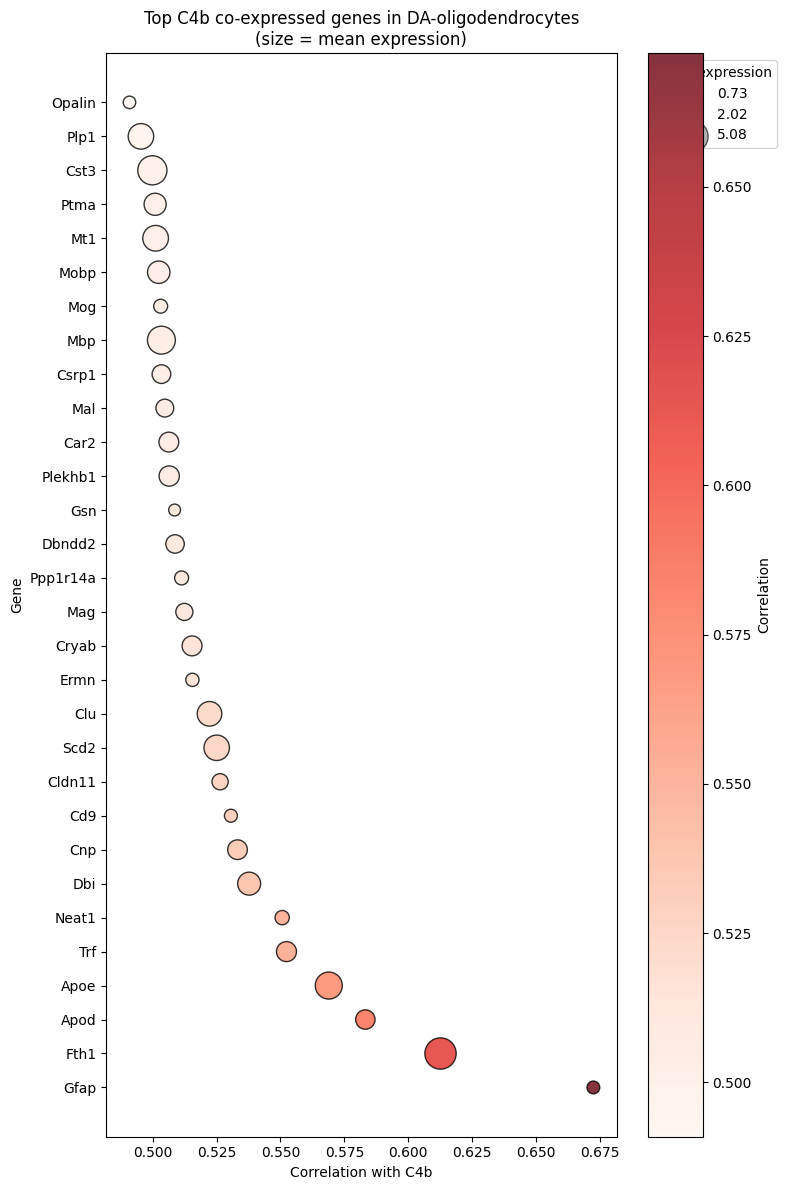

In [39]:
import matplotlib.pyplot as plt

def dotplot_corr_expr(results, top_n=30):
    """
    Dotplot of genes ranked by correlation with C4b.
    Dot size = mean expression, Dot color = correlation with C4b.
    """
    df = results.sort_values("corr_with_C4b", ascending=False).head(top_n)

    plt.figure(figsize=(8, 0.4*top_n))
    sc = plt.scatter(
        x=df["corr_with_C4b"],
        y=df["gene"],
        s=df["mean_expression"]*100,   # scale size by mean expression
        c=df["corr_with_C4b"],
        cmap="Reds",
        alpha=0.8,
        edgecolor="k"
    )

    plt.xlabel("Correlation with C4b")
    plt.ylabel("Gene")
    plt.colorbar(sc, label="Correlation")
    plt.title("Top C4b co-expressed genes in DA-oligodendrocytes\n(size = mean expression)")

    # --- add size legend, positioned outside ---
    sizes = [df["mean_expression"].min(), df["mean_expression"].median(), df["mean_expression"].max()]
    labels = [f"{s:.2f}" for s in sizes]
    handles = [plt.scatter([], [], s=s*100, color="gray", alpha=0.6, edgecolor="k") for s in sizes]

    plt.legend(
        handles, labels, title="Mean expression",
        bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True
    )

    plt.tight_layout()
    plt.show()

# usage
dotplot_corr_expr(top_genes, top_n=30)

# Regression-based approach

In [ ]:
from sklearn.linear_model import LassoCV

X = adata.to_df().drop(columns=["C4b"])
y = adata.to_df()["C4b"]

lasso = LassoCV(cv=5).fit(X, y)
coefs = pd.Series(lasso.coef_, index=X.columns)
coefs = coefs[coefs != 0].sort_values(ascending=False)
print(coefs.head(20))

# Mutual information (nonlinear associations)

In [ ]:
from sklearn.feature_selection import mutual_info_regression

X = adata.to_df().drop(columns=["C4b"])
y = adata.to_df()["C4b"]

mi = mutual_info_regression(X, y)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_scores.head(20))

# Cell-level co-expression probability

In [ ]:
X = adata.to_df()
c4b_pos = X["C4b"] > 0

coexpr_fraction = (X.loc[c4b_pos] > 0).mean()
coexpr_fraction = coexpr_fraction.sort_values(ascending=False).head(20)

In [ ]:
coexpr_fraction